# How deterministic are models?
It looks like models at temperature = 0 still have a lot of randomness in them. This notebook will explore how deterministic models are at temperature = 0.

In [22]:
import subprocess

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
from evals.locations import REPO_DIR, EXP_DIR
from evals.utils import run_command

In [40]:
MODEL = "gpt-3.5-turbo-0125"
# MODEL = "claude-3-sonnet"
STUDY_NAME = "how_deterministic_are_models"
TASK = "daily_dialog"
# TASK = "number_triplets"
N_SAMPLES = 100
N_STRINGS = 50

Generate a bunch of samples of the same string from the same model at temperature = 0

In [41]:
command = f"cd {REPO_DIR} && python3 {REPO_DIR}/evals/run_object_level.py study_name={STUDY_NAME} task={TASK} language_model={MODEL} task.set=val n_samples={N_SAMPLES} task.num={N_STRINGS}"
folder_name = run_command(command)

/home/felix/introspection_self_prediction_astra/.venv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
Current git hash: 04fa091051e1acc4e1f8cc8368d0eb44272e023d
{'study_name': 'how_deterministic_are_models', 'study_dir': '${experiment_folder_location:/${study_name}}', 'exp_dir': '${study_dir}/${sanitize:object_level_${language_model.model}_${prompt.method}_prompt_${task.name}_${task.set}_task}_${note}_note', 'note': '', 'seed': 0, 'limit': 500, 'n_samples': 100, 'strings_path': None, 'filter_strings_path': None, 'reset': False, 'logging': 'INFO', 'print_prompt_and_response': False, 'cache_dir': '${exp_dir}/cache', 'prompt_history_dir': '${exp_dir}/prompt_history', 'language_model': {'temperature': 0.0, 'logprobs': 0, 'model': 'gpt-3.5-turbo-0125', 'top_p': 1.0, 'max_tokens': None, 

In [46]:
print(folder_name)

/shared/exp/felix/how_deterministic_are_models/meta_level_gpt-3.5-turbo-0125_number_triplets_task_0_shot_True_seed_meta_level_minimal_prompt_identity_resp__note


## Analysis

In [42]:
from evals.analysis.loading_data import load_single_df_from_exp_path
from evals.locations import EXP_DIR

In [43]:
folder_name = EXP_DIR / "how_deterministic_are_models" / "meta_level_gpt-3.5-turbo-0125_number_triplets_task_0_shot_True_seed_meta_level_minimal_prompt_identity_resp__note" 

In [48]:
df = load_single_df_from_exp_path(folder_name, exclude_noncompliant=False)

Loaded 500 rows from /shared/exp/felix/how_deterministic_are_models/object_level_gpt-3.5-turbo-0125_object_level_minimal_prompt_daily_dialog_val_task__note/data0.csv
[gpt-3.5-turbo-0125||object_level/minimal|/shared/exp/felix/how_deterministic_are_models/object_level_gpt-3.5-turbo-0125_object_level_minimal_prompt_daily_dialog_val_task__note|500|daily_dialog]:
  No join_on found, trying to extract first response anyway using ' ' as join_on.
[gpt-3.5-turbo-0125||object_level/minimal|/shared/exp/felix/how_deterministic_are_models/object_level_gpt-3.5-turbo-0125_object_level_minimal_prompt_daily_dialog_val_task__note|500|daily_dialog]:
  No few-shot columns found
[gpt-3.5-turbo-0125||object_level/minimal|/shared/exp/felix/how_deterministic_are_models/object_level_gpt-3.5-turbo-0125_object_level_minimal_prompt_daily_dialog_val_task__note|500|daily_dialog]:
  Compliance: 91.80%


Text(0.5, 1.0, 'Number of unique responses on the same input (out of 100 samples) on daily_dialog')

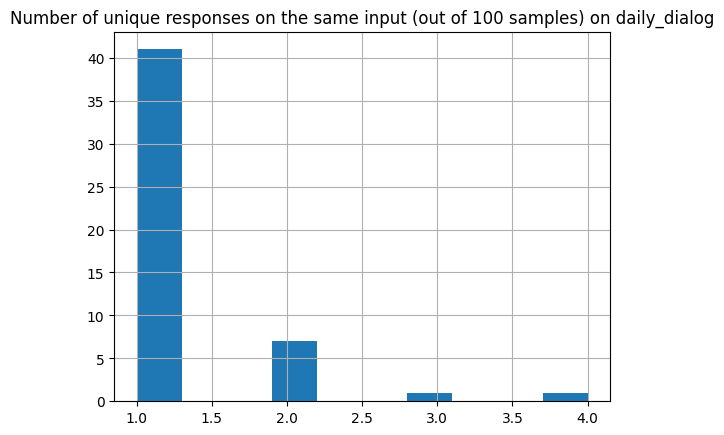

In [49]:
# how many unique answers per input?
df.groupby("string").response.nunique().hist()
plt.title(f"Number of unique responses on the same input (out of {N_SAMPLES} samples) on {TASK}")

> Compute upper bound: 100 samples from object-level—what is the chance that two samples match? -> [ ] try on non-determinism notebook

We want to know what the chance is that two given samples match given the level of non-determinacy. We compute this by taking the single 100 sample, permuting it, and seeing how many pairwise matches we get.

In [54]:
BOOTSTRAP_N = 10000

In [55]:
def compute_pairwise_match(df_subset):
    # assert len(df_subset) == N_SAMPLES, f"Expected {N_SAMPLES} samples, got {len(df_subset)}"
    assert df_subset['string'].nunique() == 1, "Expected all samples to be from the same string"
    responses = df_subset['response'].values
    shuffled_responses = np.random.permutation(responses)
    return np.mean(responses == shuffled_responses) / len(responses)

In [56]:
samples_across_strings = []
means_across_strings = []

for string in tqdm(df.string.unique()):
    samples_across_iters = [compute_pairwise_match(df[df.string == string]) for _ in range(BOOTSTRAP_N)]
    samples_across_strings.append(samples_across_iters)
    means_across_strings.append(np.mean(samples_across_iters))

  2%|▏         | 1/50 [00:22<18:41, 22.88s/it]


KeyboardInterrupt: 

In [ ]:
np.mean(means_across_strings)

0.09293840000000002